# Model Selection and Hyperparameter Tuning

A machine learning model specifies how to predict a target variable. There are many components of the model, including:

- method, e.g., linear regression, $k$-nearest neighbors regression
- parameters, e.g., $k$ in $k$-nearest neighbors
- scaling, e.g., standardization, normalization
- metric, e.g. Euclidean distance
- features, i.e., which variables to base the predictions on

There many possible prediction models in any particular situation. How do we choose? In this notebook, we will investigate two close related issues:

- Model Selection: Is $k$-nearest neighbors better or is linear regression better? Which features should we include in the model? What scaling to use?
- Hyperparameter Tuning: How do we choose hyperparameters, such as $k$ in $k$-nearest neighbors? Which metrics to use (e.g., Euclidean distance)?

The distinction between model selection and hyperparameter tuning is not important. In the previous notebook, we saw how to use cross-validation to estimate how well a model will perform on test data. A natural way to decide between competing models or hyperparameters is to choose the one that minimizes the test error.

We'll use the Bordeaux wine data as example. Recall that our target is wine quality, which we measure as the log of price. The labels are the values of log(price), which we have observed for years up to 1980. The possible features are: **summer** (average summer temperature (in degrees Celsius)), **har** and **win** (harvest and winter rainfalls (in millimeters)), and **sep** (average temperature in September).

In [1]:
import pandas as pd
import numpy as np

# Extract the training data.
data_dir = "https://dlsun.github.io/pods/data/"
bordeaux_df = pd.read_csv(data_dir + "bordeaux.csv",
                          index_col="year")

bordeaux_train = bordeaux_df.loc[:1980].copy()
bordeaux_train["log(price)"] = np.log(bordeaux_train["price"])

## Model Selection

We will first focus on which features to include in a model with a given method. Suppose we wish to fit a $5$-nearest neighbors model (using Euclidean distance as the metric), with standard scaling, but are not sure which features to include in the model. In the code below, we consider five possible sets of features.

- ["win", "summer"]
- ["win", "summer", "age"]
- ["win", "summer", "age", "sep"]
- ["win", "summer", "age", "har"]
- ["win", "summer", "age", "har", "sep"]

The following code fits each of these 5 models and estimates each model's test error, measured as MSE, using 10-fold cross validation.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# define function to calculate estimate of test error for a given feature set
def get_cv_error(features):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=5)
  )
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=bordeaux_train[features],
                             y=bordeaux_train["log(price)"],
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()
for features in [["win", "summer"],
                 ["win", "summer", "age"],
                 ["win", "summer", "age", "sep"],
                 ["win", "summer", "age", "har"],
                 ["win", "summer", "age", "har", "sep"]]:
  errs[str(features)] = get_cv_error(features)

errs

['win', 'summer']                         0.235815
['win', 'summer', 'age']                  0.228366
['win', 'summer', 'age', 'sep']           0.284661
['win', 'summer', 'age', 'har']           0.198948
['win', 'summer', 'age', 'har', 'sep']    0.237851
dtype: float64

Among these five models, which would we prefer? The one with the smallest estimated test error (MSE)! This results in the model with features:

- winter rainfall (**win**)
- average summer temperature (**summer**)
- age of the wine (**age**)
- harvest rainfall (**har**)

Notice that more features is not necessarily better. The mean-squared error actually increases when we add the average September temperature (**sep**) to the model.

There are numerous ways of automating feature selection. However, these methods are beyond the scope of this course (though you might wish to investigate some as part of your project).

## Hyperparameter Tuning

Now suppose we fit a $k$-nearest neighbors regression model using the four features ["win", "summer", "age", "har"]. How do we determine the best value of the hyperparameter $k$? We could follow a process similar to what we did above: fit the model for a variety of $k$ values, use cross-validation to estimate the test error of each model, and then choose the value of $k$ which results in the smallest test error. The following code implements this process for $k$ from 1 to 20. (We'll see an easier way to do this soon.)

3     0.174962
4     0.175315
5     0.198948
9     0.199141
8     0.210195
2     0.213024
10    0.214402
6     0.220198
7     0.228192
11    0.237055
12    0.252668
1     0.254797
13    0.256685
14    0.264675
15    0.270900
16    0.276364
17    0.281160
18    0.285790
19    0.301274
20    0.315524
dtype: float64

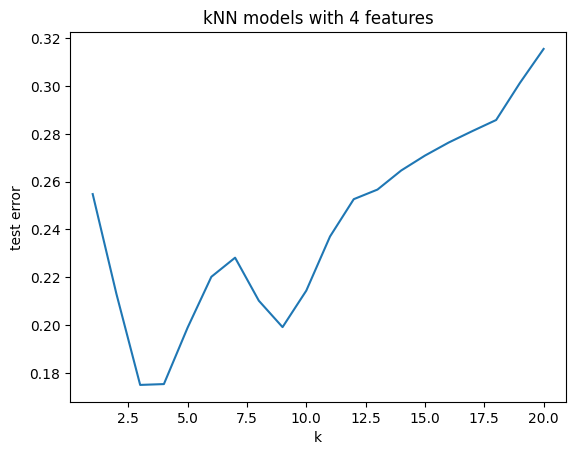

In [3]:
X_train = bordeaux_train[["win", "summer", "age", "har"]]
y_train = bordeaux_train["log(price)"]

# define function to calculate estimate of test error for a value of k
def get_cv_error(k):
  # define pipeline
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k)
  )
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()

ks = pd.Series(range(1, 21))
ks.index = range(1, 21)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line(xlabel = "k", ylabel = "test error", title = "kNN models with 4 features")
test_errs.sort_values()

The MSE is minimized at $k = 3$, which suggests that we should use a $3$-nearest neighbors model to predict wine quality. (Though $k=4$ is close behind.)

Scikit-learn provides a utility, `GridSearchCV`, that automates most of the drudgery of trying different hyperparameters. We specify `param_grid=`, which is a dictionary that maps the name of the parameter (e.g., `n_neighbors`) to a list of parameter values to try. The model with the highest score will be stored in `.best_estimator_`. (Note the trailing underscore, which indicates that this attribute is only available after `.fit()` has been called.)

For simplicity, let's start by fitting $k$-nearest neighbors to the raw data directly, without standardization.

In [4]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsRegressor(n_neighbors=5)

# GridSearchCV will replace n_neighbors by values in param_grid
grid_search = GridSearchCV(model,
                           param_grid={"n_neighbors": range(1, 20)},
                           scoring="neg_mean_squared_error",
                           cv=10)

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

KNeighborsRegressor(n_neighbors=9)

More realistically, we will want to standardize the feature variables before passing them into `KNeighborsRegressor`, so we set up a pipeline. Notice that each step in the pipeline is automatically given a name. We will need to refer to this name when using `GridSearchCV`.

In [5]:
# define pipeline
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5)
)
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

The parameter that we want to tune is `n_neighbors`, which is embedded inside the `kneighborsregressor` step of the pipeline. In `GridSearchCV`, the convention is to refer to a parameter inside a step of the pipeline as `<step>__<parameter>`; note the double-underscore. So the parameter we are tuning in this case is `kneighborsregressor__n_neighbors`.

In [6]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline,
                           param_grid={
                               "kneighborsregressor__n_neighbors": range(1, 20)
                           },
                           scoring="neg_mean_squared_error",
                           cv=10)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=3))])

Inspecting the scikit-learn model that was deemed best by `GridSearchCV`, we see that a $3$-nearest neighbors model has the lowest MSE, which agrees with what we obtained earlier. It is possible to get a complete summary of what `GridSearchCV` tried, in the attribute `.cv_results_`.

In [7]:
grid_search.cv_results_

{'mean_fit_time': array([0.00190301, 0.00142484, 0.00119565, 0.00120938, 0.00121317,
        0.0011395 , 0.00123301, 0.00128062, 0.0011806 , 0.00122609,
        0.00121772, 0.00119421, 0.00120893, 0.00122099, 0.00118394,
        0.00119793, 0.00116348, 0.00117564, 0.00119541]),
 'std_fit_time': array([3.86634770e-04, 2.07893121e-04, 8.83033959e-05, 1.32540456e-04,
        1.36755874e-04, 7.82329943e-05, 1.22508189e-04, 1.38140311e-04,
        8.27595363e-05, 1.16639535e-04, 1.09784818e-04, 7.24822635e-05,
        6.46436442e-05, 6.05277863e-05, 2.80108450e-05, 7.65322339e-05,
        3.21090614e-05, 6.92785481e-05, 6.79312607e-05]),
 'mean_score_time': array([0.00116141, 0.00078712, 0.0007489 , 0.00072627, 0.00071013,
        0.00067263, 0.00071881, 0.00077338, 0.00071929, 0.00073202,
        0.00074074, 0.00093679, 0.00111563, 0.0009537 , 0.00097635,
        0.00087049, 0.00094826, 0.00085697, 0.00088208]),
 'std_score_time': array([1.85155324e-04, 8.53879557e-05, 1.25299679e-04, 9.86

We can put the results in a data frame for easier inspection.

In [8]:
df_cv_results_ = pd.DataFrame(grid_search.cv_results_)

df_cv_results_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsregressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001903,0.000387,0.001161,0.000185,1,{'kneighborsregressor__n_neighbors': 1},-0.361332,-0.220687,-0.310999,-0.149940,-0.145804,-0.190954,-0.575210,-0.105137,-0.240643,-0.247259,-0.254797,0.129592,12
1,0.001425,0.000208,0.000787,0.000085,2,{'kneighborsregressor__n_neighbors': 2},-0.326017,-0.131215,-0.139740,-0.010067,-0.154135,-0.128007,-0.248664,-0.327767,-0.281036,-0.383595,-0.213024,0.111747,6
2,0.001196,0.000088,0.000749,0.000125,3,{'kneighborsregressor__n_neighbors': 3},-0.123133,-0.225408,-0.191006,-0.012938,-0.058157,-0.140065,-0.302492,-0.039883,-0.476921,-0.179620,-0.174962,0.131268,1
3,0.001209,0.000133,0.000726,0.000099,4,{'kneighborsregressor__n_neighbors': 4},-0.131811,-0.207109,-0.311536,-0.020388,-0.067274,-0.158115,-0.304621,-0.094865,-0.275927,-0.181501,-0.175315,0.095281,2
4,0.001213,0.000137,0.000710,0.000087,5,{'kneighborsregressor__n_neighbors': 5},-0.187130,-0.267501,-0.306202,-0.011552,-0.098984,-0.179304,-0.413373,-0.130131,-0.319585,-0.075721,-0.198948,0.119286,3
5,0.001139,0.000078,0.000673,0.000035,6,{'kneighborsregressor__n_neighbors': 6},-0.236303,-0.422840,-0.350381,-0.005549,-0.053156,-0.145877,-0.393223,-0.110521,-0.386813,-0.097311,-0.220198,0.149198,8
6,0.001233,0.000123,0.000719,0.000081,7,{'kneighborsregressor__n_neighbors': 7},-0.284726,-0.376750,-0.376427,-0.011642,-0.072069,-0.168522,-0.431720,-0.127956,-0.343267,-0.088840,-0.228192,0.143597,9
7,0.001281,0.000138,0.000773,0.000089,8,{'kneighborsregressor__n_neighbors': 8},-0.252160,-0.374866,-0.426564,-0.022956,-0.070375,-0.172620,-0.329100,-0.130639,-0.262814,-0.059860,-0.210195,0.133248,5
8,0.001181,0.000083,0.000719,0.000082,9,{'kneighborsregressor__n_neighbors': 9},-0.236383,-0.313091,-0.412172,-0.028330,-0.100585,-0.195427,-0.297543,-0.152483,-0.208077,-0.047318,-0.199141,0.115606,4
9,0.001226,0.000117,0.000732,0.000109,10,{'kneighborsregressor__n_neighbors': 10},-0.269399,-0.256886,-0.533318,-0.045470,-0.141248,-0.184236,-0.275332,-0.152262,-0.242558,-0.043317,-0.214402,0.133781,7


Now we can plot the test error versus $k$; compare to the plot from earlier in the notebook. (The `n_neighbors` parameter is a string so we convert it to int and then move it to the index to help with the line plot.)

In [9]:
df_cv_results_["param_kneighborsregressor__n_neighbors"] = df_cv_results_["param_kneighborsregressor__n_neighbors"].astype(int)

df_cv_results_.set_index("param_kneighborsregressor__n_neighbors", inplace = True)


<Axes: title={'center': 'kNN models with 4 features'}, xlabel='k', ylabel='test error'>

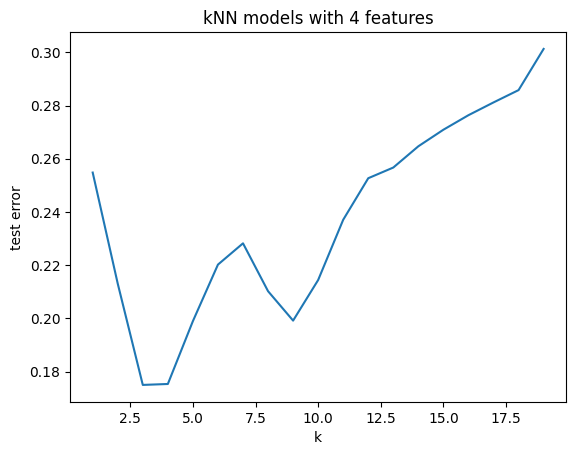

In [10]:
(-df_cv_results_["mean_test_score"]).plot.line(xlabel = "k", ylabel = "test error", title = "kNN models with 4 features")